LoRA Baseline

In [4]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from peft import get_peft_model, LoraConfig, TaskType # <-- Ganti ke LoraConfig
from datasets import load_from_disk
import evaluate
import numpy as np
import os

# ==========================================
# 1. SETUP & LOAD DATA
# ==========================================
checkpoint = "prajjwal1/bert-tiny"
dataset = load_from_disk("../data/processed/smsa_processed")

id2label = {0: "positif", 1: "netral", 2: "negatif"}
label2id = {"positif": 0, "netral": 1, "negatif": 2}

# ==========================================
# 2. LOAD BASE MODEL
# ==========================================
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

# ==========================================
# 3. HYPERPARAMETER (SAMA PERSIS DENGAN ADALORA)
# ==========================================
BATCH_SIZE = 32
NUM_EPOCHS = 30 
learning_rate = 5e-4 

# ==========================================
# 4. KONFIGURASI LoRA (FIXED RANK)
# ==========================================
# Kita pakai r=8 untuk menandingi target_r=8 milik AdaLoRA
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    r=8,                   # FIXED RANK (Baseline comparison)
    lora_alpha=16,         # Scaling factor (biasanya 2x dari r)
    target_modules=["query", "value"], 
    lora_dropout=0.1,      
    bias="none"
)

model = get_peft_model(model, peft_config)
print("\n=== PARAMETER LoRA BASELINE ===")
model.print_trainable_parameters()

# ==========================================
# 5. METRIC
# ==========================================
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# ==========================================
# 6. TRAINING ARGUMENTS
# ==========================================
output_dir = "model_output/smsa_lora_baseline" # <-- Nama folder output beda

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=learning_rate,      # 5e-4
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    
    # Strategi Evaluasi
    eval_strategy="epoch", 
    save_strategy="epoch",
    load_best_model_at_end=True,
    
    metric_for_best_model="accuracy", 
    greater_is_better=True,           
    save_total_limit=2,               
    
    logging_steps=50,   
    report_to="none",
)

# Inisialisasi Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=AutoTokenizer.from_pretrained(checkpoint),
    compute_metrics=compute_metrics,
)

print("\n🚀 Mulai Training LoRA Baseline (Fixed Rank 8)...")
trainer.train()

# ==========================================
# 7. SAVE MODEL FINAL
# ==========================================
save_path = "saved_models/smsa_lora_baseline_best"
os.makedirs(save_path, exist_ok=True)

trainer.save_model(save_path)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.save_pretrained(save_path)

print(f"✅ Best Model LoRA Baseline disimpan di: {save_path}")

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

d:\anaconda3\envs\ta_dl\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\models--prajjwal1--bert-tiny. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For 

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== PARAMETER LoRA BASELINE ===
trainable params: 8,579 || all params: 4,394,886 || trainable%: 0.1952


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1368\1549524518.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



🚀 Mulai Training LoRA Baseline (Fixed Rank 8)...


d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.686900,1.142369,0.404000
2,0.602900,1.079901,0.480000
3,0.542500,1.014678,0.506000
4,0.586900,1.018015,0.530000
5,0.546600,1.038860,0.508000
6,0.540800,0.999155,0.546000
7,0.530200,1.076571,0.504000
8,0.521000,1.090706,0.518000
9,0.504100,1.028500,0.546000
10,0.538300,1.027350,0.546000


d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' 

✅ Best Model LoRA Baseline disimpan di: saved_models/smsa_lora_baseline_best


Script Visualisasi & Evaluasi (Khusus LoRA)

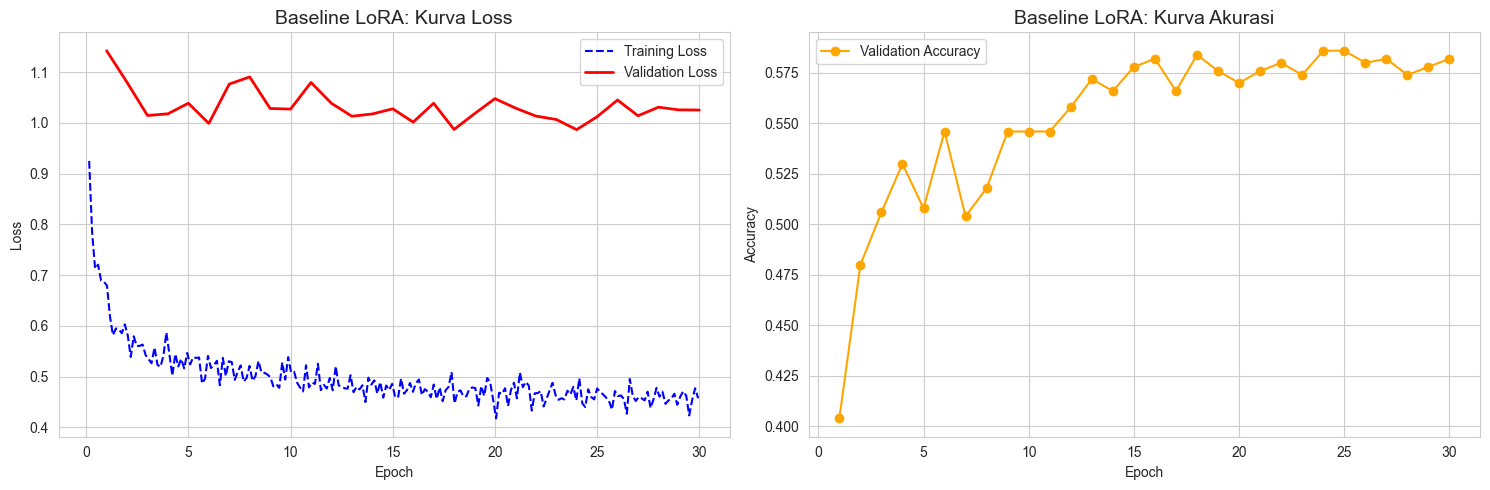


🔍 Menjalankan Evaluasi Akhir pada LoRA Baseline...


Testing LoRA:   0%|          | 0/16 [00:00<?, ?it/s]

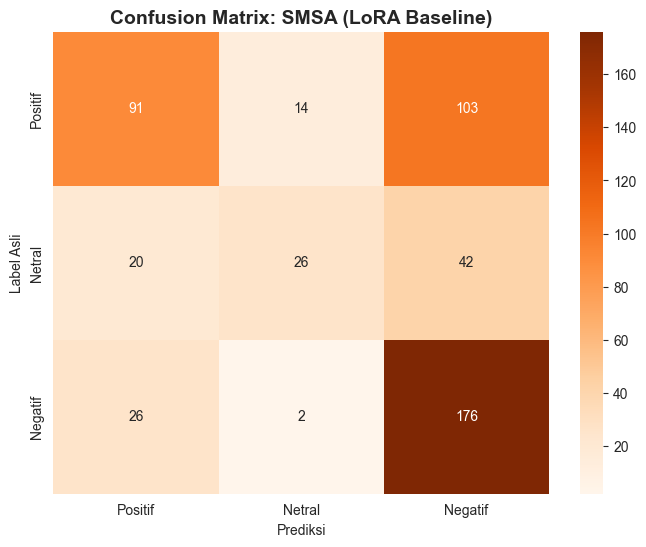


HASIL AKHIR SMSA - LoRA BASELINE (Rank 8)
              precision    recall  f1-score   support

     Positif     0.6642    0.4375    0.5275       208
      Netral     0.6190    0.2955    0.4000        88
     Negatif     0.5483    0.8627    0.6705       204

    accuracy                         0.5860       500
   macro avg     0.6105    0.5319    0.5327       500
weighted avg     0.6090    0.5860    0.5634       500



In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding

# ============================
# PART A: KURVA TRAINING
# ============================
history = trainer.state.log_history
df = pd.DataFrame(history)

train_loss = df[df['loss'].notna()][['epoch', 'loss']]
val_loss = df[df['eval_loss'].notna()][['epoch', 'eval_loss']]
val_acc = df[df['eval_accuracy'].notna()][['epoch', 'eval_accuracy']]

plt.figure(figsize=(15, 5))
sns.set_style("whitegrid")

# Grafik Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss['epoch'], train_loss['loss'], label='Training Loss', color='blue', linestyle='--')
plt.plot(val_loss['epoch'], val_loss['eval_loss'], label='Validation Loss', color='red', linewidth=2)
plt.title('Baseline LoRA: Kurva Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Grafik Akurasi
plt.subplot(1, 2, 2)
plt.plot(val_acc['epoch'], val_acc['eval_accuracy'], label='Validation Accuracy', color='orange', marker='o')
plt.title('Baseline LoRA: Kurva Akurasi', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# ============================
# PART B: EVALUASI MANUAL
# ============================
print("\n🔍 Menjalankan Evaluasi Akhir pada LoRA Baseline...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
test_loader = DataLoader(dataset["test"], batch_size=32, collate_fn=data_collator)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing LoRA"):
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch.pop("labels")
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
label_names = ["Positif", "Netral", "Negatif"]
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', # Pakai warna beda biar gak ketukar sama AdaLoRA
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix: SMSA (LoRA Baseline)', fontsize=14, fontweight='bold')
plt.xlabel('Prediksi')
plt.ylabel('Label Asli')
plt.show()

print("\n" + "="*50)
print("HASIL AKHIR SMSA - LoRA BASELINE (Rank 8)")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=label_names, digits=4))

emot

In [6]:
# ==========================================
# 1. SETUP DATA & MODEL
# ==========================================
# Path pakai "../" untuk mundur satu folder dari 'notebooks' ke 'data'
dataset = load_from_disk("../data/processed/emot_processed") 

checkpoint = "prajjwal1/bert-tiny"

# Label Mapping untuk EMOT (5 Label)
id2label = {0: "sadness", 1: "anger", 2: "love", 3: "fear", 4: "happy"}
label2id = {"sadness": 0, "anger": 1, "love": 2, "fear": 3, "happy": 4}

# Load Base Model
model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint, 
    num_labels=5,         # PENTING: 5 Kelas
    id2label=id2label,
    label2id=label2id
)

# ==========================================
# 2. HYPERPARAMETER (SAMA DENGAN SEBELUMNYA)
# ==========================================
BATCH_SIZE = 32
NUM_EPOCHS = 15 
learning_rate = 5e-4 

# ==========================================
# 3. KONFIGURASI LoRA (FIXED RANK)
# ==========================================
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    r=8,                   # FIXED RANK (Baseline)
    lora_alpha=16,         # Scaling standard
    target_modules=["query", "value"], 
    lora_dropout=0.1, 
    bias="none"
)

# Bungkus model dengan LoRA
model = get_peft_model(model, peft_config)
print("\n=== PARAMETER MODEL (LoRA Baseline) ===")
model.print_trainable_parameters() 

# ==========================================
# 4. METRIC & TRAINER
# ==========================================
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Output directory beda nama biar gak numpuk
output_dir = "model_output/emot_lora_baseline"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=learning_rate, 
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    
    eval_strategy="epoch", 
    save_strategy="epoch",
    load_best_model_at_end=True,
    
    metric_for_best_model="accuracy", 
    greater_is_better=True,           
    save_total_limit=2,               
    
    logging_steps=50,   
    report_to="none",
)

# Custom Trainer (Kita pertahankan ini jaga-jaga ada bug 'num_items_in_batch')
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if "num_items_in_batch" in inputs:
            del inputs["num_items_in_batch"]
        return super().compute_loss(model, inputs, return_outputs)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"], 
    eval_dataset=dataset["test"], 
    tokenizer=AutoTokenizer.from_pretrained(checkpoint),
    compute_metrics=compute_metrics,
)

print("\n🚀 Mulai Training EMOT - LoRA Baseline (Rank 8)...")
trainer.train()

# ==========================================
# 5. SIMPAN MODEL
# ==========================================
save_path = "saved_models/emot_lora_baseline_best"
os.makedirs(save_path, exist_ok=True)

trainer.save_model(save_path)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.save_pretrained(save_path)

print(f"✅ Model EMOT LoRA Baseline disimpan di: {save_path}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== PARAMETER MODEL (LoRA Baseline) ===
trainable params: 8,837 || all params: 4,395,402 || trainable%: 0.2011


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1368\1451831943.py:85: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(



🚀 Mulai Training EMOT - LoRA Baseline (Rank 8)...


d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.577200,1.567234,0.281818
2,1.537800,1.539859,0.265909
3,1.480800,1.484684,0.320455
4,1.439200,1.467956,0.354545
5,1.413800,1.444293,0.347727
6,1.400600,1.437432,0.365909
7,1.370500,1.417668,0.375000
8,1.350100,1.395546,0.395455
9,1.325800,1.372717,0.438636
10,1.341400,1.363579,0.418182


d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' 

✅ Model EMOT LoRA Baseline disimpan di: saved_models/emot_lora_baseline_best


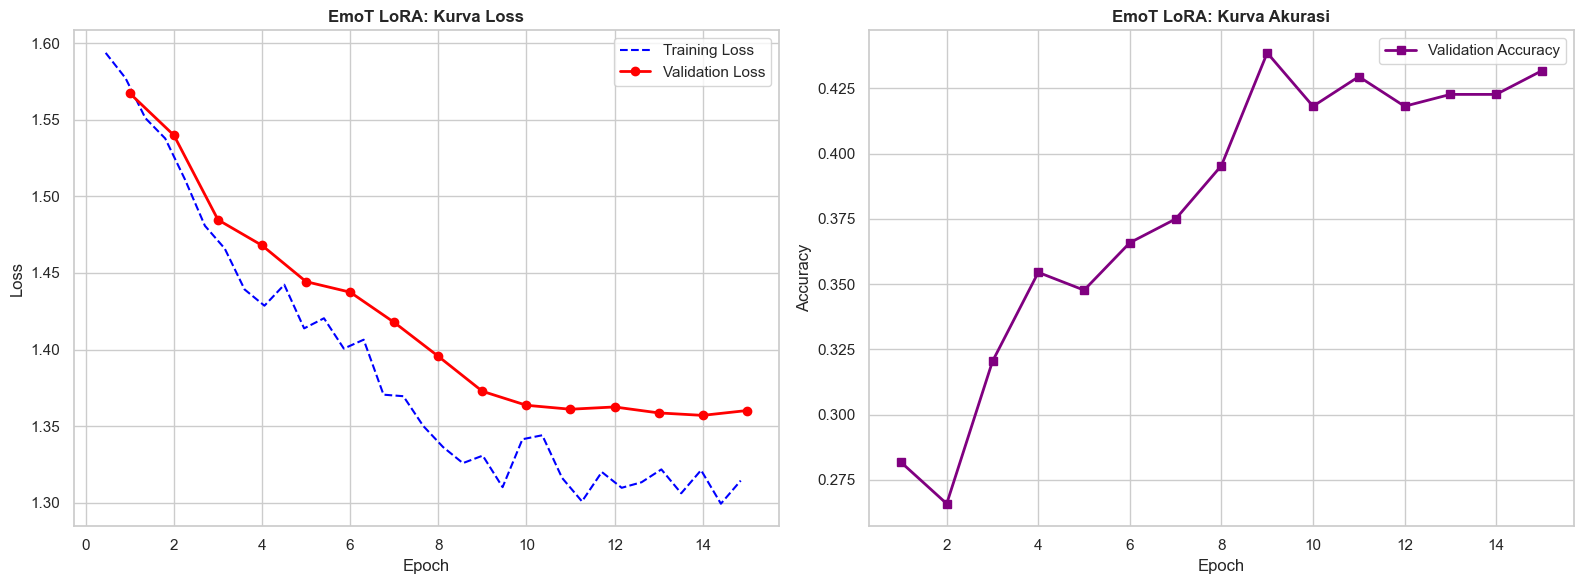


Sedang memprediksi data test...


d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


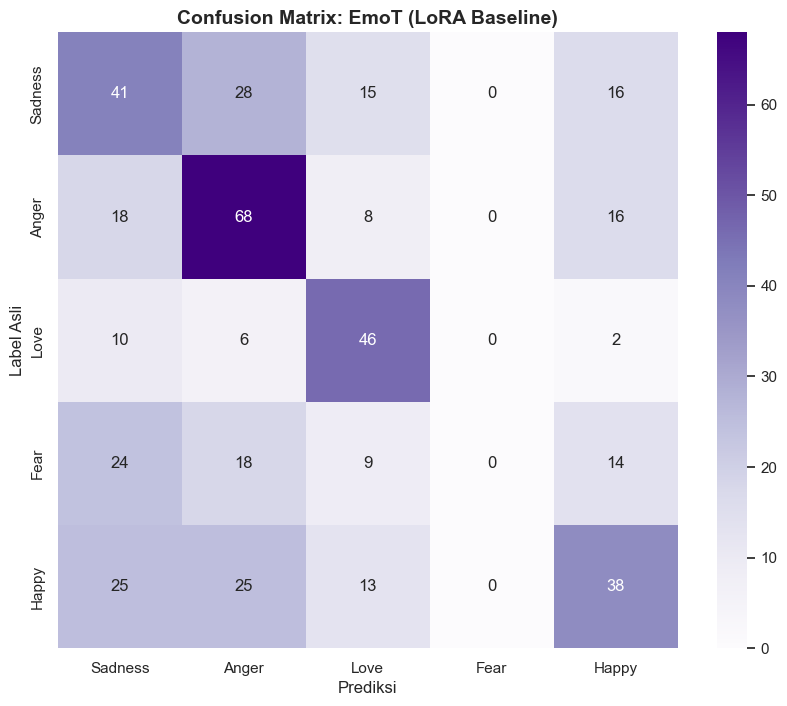


HASIL AKHIR EMOT - LoRA BASELINE
              precision    recall  f1-score   support

     Sadness     0.3475    0.4100    0.3761       100
       Anger     0.4690    0.6182    0.5333       110
        Love     0.5055    0.7188    0.5935        64
        Fear     0.0000    0.0000    0.0000        65
       Happy     0.4419    0.3762    0.4064       101

    accuracy                         0.4386       440
   macro avg     0.3528    0.4246    0.3819       440
weighted avg     0.3712    0.4386    0.3984       440



d:\anaconda3\envs\ta_dl\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\anaconda3\envs\ta_dl\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\anaconda3\envs\ta_dl\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [7]:

# ==========================================
# PART A: KURVA BELAJAR
# ==========================================
history = trainer.state.log_history
df = pd.DataFrame(history)

train_history = df[df['loss'].notna()]
val_history = df[df['eval_loss'].notna()]

plt.figure(figsize=(16, 6))
sns.set_theme(style="whitegrid")

# Grafik Loss
plt.subplot(1, 2, 1)
plt.plot(train_history['epoch'], train_history['loss'], label='Training Loss', color='blue', linestyle='--')
plt.plot(val_history['epoch'], val_history['eval_loss'], label='Validation Loss', color='red', linewidth=2, marker='o')
plt.title('EmoT LoRA: Kurva Loss', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Grafik Akurasi
plt.subplot(1, 2, 2)
plt.plot(val_history['epoch'], val_history['eval_accuracy'], label='Validation Accuracy', color='purple', linewidth=2, marker='s')
plt.title('EmoT LoRA: Kurva Akurasi', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# ==========================================
# PART B: PREDIKSI & CONFUSION MATRIX
# ==========================================
print("\nSedang memprediksi data test...")
predictions_output = trainer.predict(dataset["test"])
y_pred = np.argmax(predictions_output.predictions, axis=1)
y_true = predictions_output.label_ids

label_names = ["Sadness", "Anger", "Love", "Fear", "Happy"]

# Heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
# Pakai warna 'Purples' biar beda nuansa dengan AdaLoRA
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix: EmoT (LoRA Baseline)', fontsize=14, fontweight='bold')
plt.xlabel('Prediksi')
plt.ylabel('Label Asli')
plt.show()

# Laporan Lengkap
print("\n" + "="*50)
print("HASIL AKHIR EMOT - LoRA BASELINE")
print("="*50)
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

nerp

In [8]:
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForTokenClassification, 
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer
)
from peft import get_peft_model, LoraConfig, TaskType # <-- Pakai LoraConfig
from datasets import load_from_disk, concatenate_datasets
import evaluate
import numpy as np
import os

# ==========================================
# 1. PERSIAPAN DATA
# ==========================================
print("🚀 Memulai Training NERP (LoRA Baseline)...")

# Path Mundur satu langkah (../)
try:
    dataset_raw = load_from_disk("../data/processed/nerp_processed")
    print("✅ Dataset raw berhasil diload.")
except:
    # Fallback kalau path-nya beda
    dataset_raw = load_from_disk("processed_data/nerp_processed") 

# --- FORCE RESPLIT 80:20 (Sesuai kode kamu) ---
print("🔄 Memastikan Split 80% Train : 20% Test...")

if isinstance(dataset_raw, dict) or hasattr(dataset_raw, "keys"):
    keys = list(dataset_raw.keys())
    if "train" in keys and "test" in keys:
        full_data = concatenate_datasets([dataset_raw["train"], dataset_raw["test"]])
        dataset = full_data.train_test_split(test_size=0.2)
    elif "train" in keys:
        dataset = dataset_raw["train"].train_test_split(test_size=0.2)
    else:
        dataset = dataset_raw.train_test_split(test_size=0.2)
else:
    dataset = dataset_raw.train_test_split(test_size=0.2)

print(f"✅ DATA READY! Train: {len(dataset['train'])}, Test: {len(dataset['test'])}")

# ==========================================
# 2. CONFIG MODEL & LABEL
# ==========================================
# 11 Label NERP
label_list = [
    "O", "B-PER", "I-PER", "B-ORG", "I-ORG", 
    "B-LOC", "I-LOC", "B-MISC", "I-MISC", 
    "LABEL_9", "LABEL_10"
]
id2label = {i: l for i, l in enumerate(label_list)}
label2id = {l: i for i, l in enumerate(label_list)}

checkpoint = "prajjwal1/bert-tiny"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Load Base Model
model = AutoModelForTokenClassification.from_pretrained(
    checkpoint, num_labels=len(label_list), id2label=id2label, label2id=label2id
)

# --- KONFIGURASI LoRA (FIXED RANK) ---
peft_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,  # WAJIB TOKEN_CLS
    inference_mode=False, 
    r=8,                   # FIXED RANK (Baseline)
    lora_alpha=16,         # Standard scaling
    lora_dropout=0.1, 
    bias="none",
    target_modules=["query", "value"]
)

model = get_peft_model(model, peft_config)
print("\n=== PARAMETER MODEL (LoRA Baseline) ===")
model.print_trainable_parameters()

# ==========================================
# 3. METRIK (SEQEVAL)
# ==========================================
# Pastikan library seqeval terinstall: pip install seqeval
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Filter -100 (Padding) agar tidak dihitung skor
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# ==========================================
# 4. TRAINER
# ==========================================
# Custom Trainer untuk handle bug num_items_in_batch
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if "num_items_in_batch" in inputs: del inputs["num_items_in_batch"]
        return super().compute_loss(model, inputs, return_outputs)

output_dir = "model_output/nerp_lora_baseline"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-3,          # Mengikuti settingan AdaLoRA kamu
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,         # Mengikuti settingan AdaLoRA kamu (10 Epoch)
    weight_decay=0.01,
    save_strategy="epoch",
    eval_strategy="epoch",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",  # Untuk NER biasanya F1 lebih penting dari Accuracy
    greater_is_better=True,
    report_to="none"
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("\n⏳ Mulai Training NER - LoRA Baseline (Rank 8)...")
trainer.train()

# ==========================================
# 5. SIMPAN MODEL
# ==========================================
save_path = "saved_models/nerp_lora_baseline_best"
os.makedirs(save_path, exist_ok=True)
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)
print(f"\n💾 Model LoRA Baseline Berhasil Disimpan di: {save_path}")

🚀 Memulai Training NERP (LoRA Baseline)...
✅ Dataset raw berhasil diload.
🔄 Memastikan Split 80% Train : 20% Test...
✅ DATA READY! Train: 6048, Test: 1512


Some weights of BertForTokenClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== PARAMETER MODEL (LoRA Baseline) ===
trainable params: 9,611 || all params: 4,380,438 || trainable%: 0.2194


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1368\2879582497.py:136: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(



⏳ Mulai Training NER - LoRA Baseline (Rank 8)...


d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.613400,0.571087,0.298866,0.077284,0.122810,0.857065
2,0.536700,0.496182,0.403503,0.156679,0.225714,0.867909
3,0.515200,0.464959,0.437687,0.205934,0.280086,0.873504
4,0.477500,0.448570,0.444715,0.235370,0.307822,0.875811
5,0.485800,0.443350,0.446199,0.215433,0.290573,0.875811
6,0.474500,0.433186,0.454075,0.236543,0.311049,0.877513
7,0.486600,0.433800,0.461225,0.225988,0.303345,0.877945
8,0.463600,0.424500,0.466387,0.247332,0.323243,0.879734
9,0.469900,0.424799,0.470025,0.241820,0.319343,0.879993
10,0.484100,0.421527,0.470329,0.250029,0.326493,0.880310


d:\anaconda3\envs\ta_dl\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: LABEL_9 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\anaconda3\envs\ta_dl\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: LABEL_10 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\anaconda3\envs\ta_dl\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\anaconda3\envs\ta_dl\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: L


💾 Model LoRA Baseline Berhasil Disimpan di: saved_models/nerp_lora_baseline_best


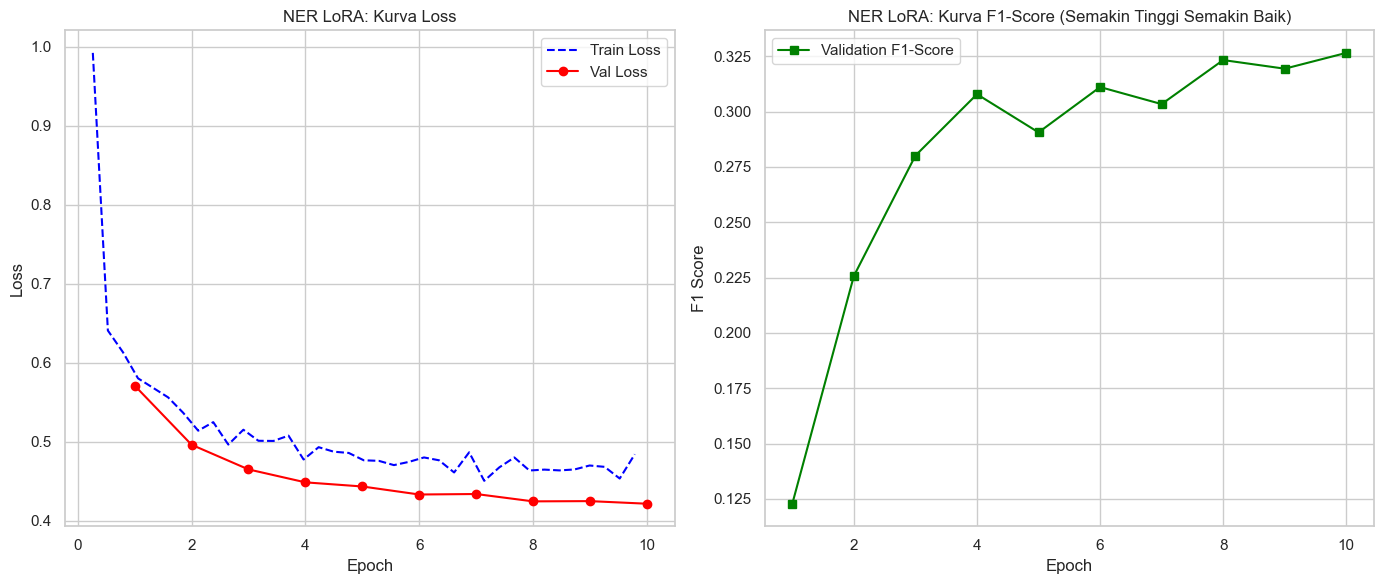


📊 Membuat Confusion Matrix & Laporan Detail...


d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


d:\anaconda3\envs\ta_dl\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: LABEL_9 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
d:\anaconda3\envs\ta_dl\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: LABEL_10 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


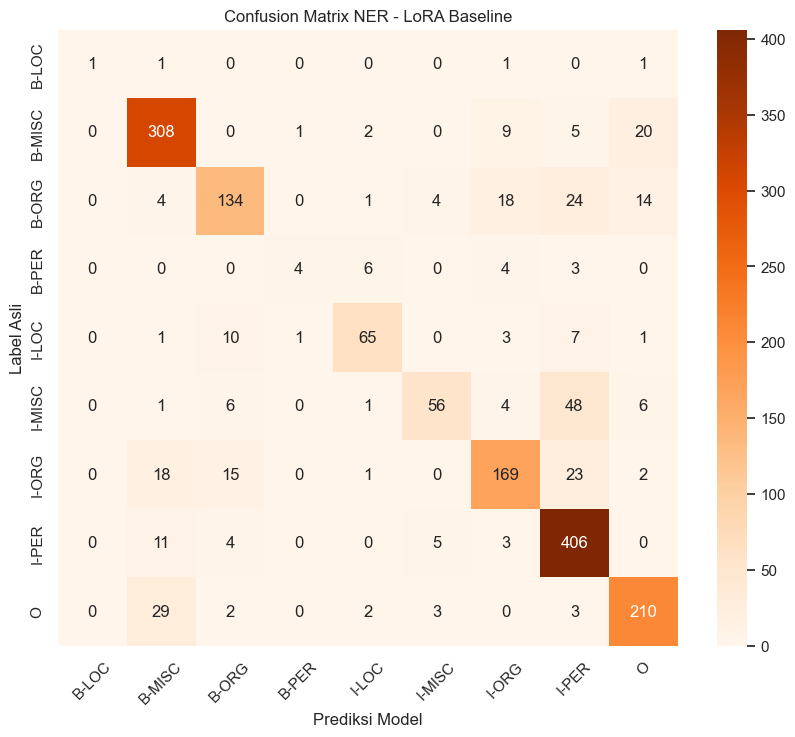


🏆 HASIL AKHIR NERP - LoRA BASELINE:
              precision    recall  f1-score   support

       B-LOC     1.0000    0.0078    0.0155       128
      B-MISC     0.7032    0.2862    0.4069      1076
       B-ORG     0.6351    0.2505    0.3592       535
       B-PER     0.5000    0.0179    0.0346       223
       I-LOC     0.6436    0.1747    0.2748       372
      I-MISC     0.7368    0.1279    0.2179       438
       I-ORG     0.6036    0.2256    0.3285       749
       I-PER     0.6711    0.4194    0.5162       968
           O     0.7241    0.3387    0.4615       620

   micro avg     0.6731    0.2648    0.3801      5109
   macro avg     0.6908    0.2054    0.2906      5109
weighted avg     0.6750    0.2648    0.3659      5109



In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Ambil history
history = pd.DataFrame(trainer.state.log_history)

# A. Kurva Loss & Metrics
plt.figure(figsize=(14, 6))

# Grafik Loss
plt.subplot(1, 2, 1)
loss_data = history.dropna(subset=['loss'])
val_loss_data = history.dropna(subset=['eval_loss'])

plt.plot(loss_data['epoch'], loss_data['loss'], label='Train Loss', linestyle='--', color='blue')
plt.plot(val_loss_data['epoch'], val_loss_data['eval_loss'], label='Val Loss', marker='o', color='red')
plt.title("NER LoRA: Kurva Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Grafik F1 Score (Metrik Utama NER)
plt.subplot(1, 2, 2)
if 'eval_f1' in history.columns:
    val_f1_data = history.dropna(subset=['eval_f1'])
    plt.plot(val_f1_data['epoch'], val_f1_data['eval_f1'], label='Validation F1-Score', marker='s', color='green')
    plt.title("NER LoRA: Kurva F1-Score (Semakin Tinggi Semakin Baik)")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()
else:
    print("⚠️ F1 Score belum tersedia di log.")
    
plt.tight_layout()
plt.show()

# B. Confusion Matrix (Level Token)
print("\n📊 Membuat Confusion Matrix & Laporan Detail...")
predictions, labels, _ = trainer.predict(dataset["test"])
predictions = np.argmax(predictions, axis=2)

true_labels = []
true_preds = []

# Unroll token (Flat list) dan buang padding (-100)
for i in range(len(labels)):
    for j in range(len(labels[i])):
        if labels[i][j] != -100:
            true_labels.append(label_list[labels[i][j]])
            true_preds.append(label_list[predictions[i][j]])

# Buang label sampah/jarang jika ada
unique_labels = sorted(list(set(true_labels + true_preds)))
display_labels = [l for l in unique_labels if "LABEL" not in l] 

# Plot
cm = confusion_matrix(true_labels, true_preds, labels=display_labels)
plt.figure(figsize=(10, 8))
# Pakai warna 'Oranges' untuk membedakan dengan AdaLoRA
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=display_labels, yticklabels=display_labels)
plt.title('Confusion Matrix NER - LoRA Baseline')
plt.ylabel('Label Asli')
plt.xlabel('Prediksi Model')
plt.xticks(rotation=45)
plt.show()

print("\n🏆 HASIL AKHIR NERP - LoRA BASELINE:")
print(classification_report(true_labels, true_preds, labels=display_labels, digits=4))

QA

In [11]:
import torch
from transformers import (
    AutoModelForQuestionAnswering, 
    AutoTokenizer, 
    TrainingArguments, 
    Trainer,
    DefaultDataCollator
)

# ==========================================
# 1. SETUP DATA & MODEL
# ==========================================
print("🚀 Memulai Pipeline SQuAD (LoRA Baseline)...")

# Path Mundur satu langkah (../)
try:
    dataset_raw = load_from_disk("../data/processed/squad_processed")
    print("✅ Dataset raw berhasil diload.")
except:
    dataset_raw = load_from_disk("processed_data/squad_processed") 

# --- SPLIT 80:20 (Sama seperti AdaLoRA) ---
print("🔄 Membagi dataset menjadi Train (80%) & Validation (20%)...")
dataset = dataset_raw.train_test_split(test_size=0.2)
print(f"✅ Data Siap! Train: {len(dataset['train'])}, Test: {len(dataset['test'])}")

checkpoint = "prajjwal1/bert-tiny"
model = AutoModelForQuestionAnswering.from_pretrained(checkpoint)

# ==========================================
# 2. CONFIG LoRA (FIXED RANK)
# ==========================================
peft_config = LoraConfig(
    task_type=TaskType.QUESTION_ANS, # <--- Tipe Task QA
    inference_mode=False, 
    r=8,                   # FIXED RANK (Baseline)
    lora_alpha=16,         # Standard scaling
    target_modules=["query", "value"],
    lora_dropout=0.01,     # Sesuai config AdaLoRA kamu
    bias="none"
)

model = get_peft_model(model, peft_config)
print("\n=== PARAMETER MODEL (LoRA Baseline) ===")
model.print_trainable_parameters()

# ==========================================
# 3. TRAINER & ARGS
# ==========================================
# Data Collator default sudah cukup untuk QA (batching tensor)
data_collator = DefaultDataCollator()

# Custom Trainer (Anti Bug 'num_items_in_batch')
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        if "num_items_in_batch" in inputs:
            del inputs["num_items_in_batch"]
        return super().compute_loss(model, inputs, return_outputs)

output_dir = "model_output/squad_lora_baseline"

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-3,             # Sama dengan AdaLoRA
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,            # Sama dengan AdaLoRA (20 Epoch)
    weight_decay=0.01,
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    
    logging_steps=10,
    report_to="none"
)

trainer = CustomTrainer( 
    model=model,
    args=training_args,
    train_dataset=dataset["train"], 
    eval_dataset=dataset["test"],   
    tokenizer=AutoTokenizer.from_pretrained(checkpoint),
    data_collator=data_collator,
)

print("\n⏳ Mulai Training SQuAD - LoRA Baseline (Rank 8)...")
trainer.train()

# ==========================================
# 4. SIMPAN MODEL FINAL
# ==========================================
save_path = "saved_models/squad_lora_baseline_best"
os.makedirs(save_path, exist_ok=True)

trainer.save_model(save_path)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.save_pretrained(save_path)

print(f"\n✅ Model QA Baseline tersimpan di: {save_path}")

🚀 Memulai Pipeline SQuAD (LoRA Baseline)...
✅ Dataset raw berhasil diload.
🔄 Membagi dataset menjadi Train (80%) & Validation (20%)...
✅ Data Siap! Train: 110125, Test: 27532


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== PARAMETER MODEL (LoRA Baseline) ===
trainable params: 8,450 || all params: 4,378,116 || trainable%: 0.1930


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_1368\2826016742.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(



⏳ Mulai Training SQuAD - LoRA Baseline (Rank 8)...


Epoch,Training Loss,Validation Loss
1,3.021500,3.083611



✅ Model QA Baseline tersimpan di: saved_models/squad_lora_baseline_best



📊 Membuat Grafik Kurva Loss...


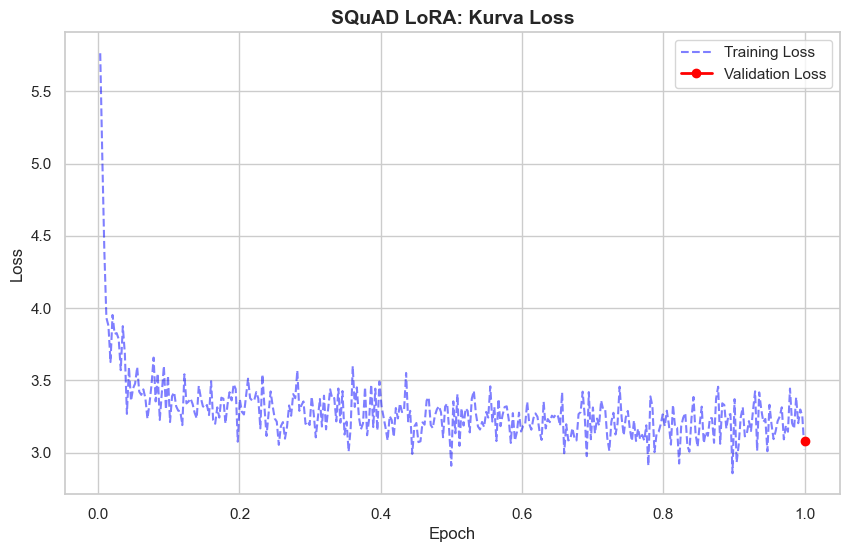


🔍 Memeriksa Kualitas Jawaban Model Baseline...


Inference:   0%|          | 0/10 [00:00<?, ?it/s]


=== CONTOH HASIL PREDIKSI (LoRA BASELINE) ===
  Jawaban Model (LoRA Baseline)                   Kunci Jawaban  Status
0                                                       ratusan  ❌ BEDA
1                                                                 ✅ PAS
2                                                                 ✅ PAS
3                                                                 ✅ PAS
4                                penulis lagu top 20 hot 100 ",  ❌ BEDA
5                                                    blok timur  ❌ BEDA
6                                                         piano  ❌ BEDA
7                                                         tujuh  ❌ BEDA
8                                                                 ✅ PAS
9                                                                 ✅ PAS


In [12]:
# ==========================================
# A. VISUALISASI KURVA LOSS
# ==========================================
print("\n📊 Membuat Grafik Kurva Loss...")
history = pd.DataFrame(trainer.state.log_history)

train_history = history[history['loss'].notna()]
val_history = history[history['eval_loss'].notna()]

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")

plt.plot(train_history['epoch'], train_history['loss'], 
         label='Training Loss', color='blue', alpha=0.5, linestyle='--')
plt.plot(val_history['epoch'], val_history['eval_loss'], 
         label='Validation Loss', color='red', linewidth=2, marker='o')

plt.title('SQuAD LoRA: Kurva Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ==========================================
# B. CEK JAWABAN (INFERENCE MANUAL)
# ==========================================
print("\n🔍 Memeriksa Kualitas Jawaban Model Baseline...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Ambil 10 sampel acak dari data test untuk diuji
eval_loader = DataLoader(dataset["test"].select(range(10)), batch_size=1, collate_fn=data_collator)

results = []
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

with torch.no_grad():
    for batch in tqdm(eval_loader, desc="Inference"):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward Pass
        outputs = model(**batch)
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits
        
        # Prediksi Posisi Start & End
        answer_start = torch.argmax(start_logits)
        answer_end = torch.argmax(end_logits) + 1
        
        # Decode Prediksi jadi Teks
        input_ids = batch["input_ids"][0].cpu().tolist()
        if answer_end < answer_start: answer_end = answer_start + 1 # Jaga-jaga error posisi
        
        pred_tokens = input_ids[answer_start : answer_end]
        pred_text = tokenizer.decode(pred_tokens, skip_special_tokens=True)
        
        # Ambil Kunci Jawaban Asli
        if "start_positions" in batch:
            true_start = batch["start_positions"][0].item()
            true_end = batch["end_positions"][0].item() + 1
            true_tokens = input_ids[true_start : true_end]
            true_text = tokenizer.decode(true_tokens, skip_special_tokens=True)
        else:
            true_text = "N/A"

        results.append({
            "Jawaban Model (LoRA Baseline)": pred_text,
            "Kunci Jawaban": true_text,
            "Status": "✅ PAS" if pred_text.strip().lower() == true_text.strip().lower() else "❌ BEDA"
        })

# Tampilkan Tabel
df_res = pd.DataFrame(results)
print("\n=== CONTOH HASIL PREDIKSI (LoRA BASELINE) ===")
pd.set_option('display.max_colwidth', None)
print(df_res)

NLG

In [ ]:
import torch
from transformers import (
    AutoModelForSeq2SeqLM, 
    AutoTokenizer, 
    Seq2SeqTrainingArguments, 
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
from peft import get_peft_model, LoraConfig, TaskType # <-- Pakai LoraConfig
from datasets import load_from_disk
import evaluate
import numpy as np
import os
import nltk
nltk.download('punkt')

# ==========================================
# 1. SETUP DATA & MODEL
# ==========================================
print("🚀 Memulai Pipeline Summarization (LoRA Baseline)...")
model_checkpoint = "google/mt5-small"

# Path Mundur satu langkah (../)
try:
    dataset_raw = load_from_disk("../data/processed/wikilingua_mt5_processed")
    print("✅ Dataset raw berhasil diload.")
except:
    dataset_raw = load_from_disk("processed_data/wikilingua_mt5_processed") 

# --- SPLIT 80:20 (Jaga-jaga kalau belum di-split) ---
if "train" not in dataset_raw:
    print("⚠️ Dataset belum di-split. Melakukan split otomatis 80/20...")
    dataset = dataset_raw.train_test_split(test_size=0.2)
else:
    dataset = dataset_raw

print(f"✅ Data Siap! Train: {len(dataset['train'])}, Test: {len(dataset['test'])}")

# Load Tokenizer & Model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

# ==========================================
# 2. CONFIG LoRA (FIXED RANK)
# ==========================================
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM, # <--- Task Summarization
    inference_mode=False, 
    r=8,                   # FIXED RANK (Baseline)
    lora_alpha=16,         # Standard scaling
    target_modules=["q", "v"], # Module Attention di T5
    lora_dropout=0.01,     # Sesuai config AdaLoRA kamu
    bias="none"
)

model = get_peft_model(model, peft_config)
print("\n=== PARAMETER MODEL (LoRA Baseline) ===")
model.print_trainable_parameters()

# ==========================================
# 3. METRIC (ROUGE)
# ==========================================
rouge = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Ganti -100 dengan pad token agar tidak error saat decode
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # ROUGE butuh format text
    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

# ==========================================
# 4. TRAINER
# ==========================================
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)
output_dir = "model_output/wikilingua_lora_baseline"

training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    learning_rate=1e-3,             # Sama dengan AdaLoRA
    per_device_train_batch_size=8,  # Sama dengan AdaLoRA
    per_device_eval_batch_size=8,
    num_train_epochs=1,            # Sama dengan AdaLoRA
    weight_decay=0.01,
    
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    predict_with_generate=True,     # WAJIB True untuk hitung ROUGE saat training
    fp16=False,                     # CPU friendly
    
    logging_steps=10,
    report_to="none"
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("\n⏳ Mulai Training WikiLingua - LoRA Baseline (Rank 8)...")
trainer.train()

# ==========================================
# 5. SIMPAN MODEL
# ==========================================
save_path = "saved_models/wikilingua_lora_baseline_best"
os.makedirs(save_path, exist_ok=True)

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print(f"\n✅ Model Summarization Baseline tersimpan di: {save_path}")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


🚀 Memulai Pipeline Summarization (LoRA Baseline)...
✅ Dataset raw berhasil diload.
⚠️ Dataset belum di-split. Melakukan split otomatis 80/20...
✅ Data Siap! Train: 13046, Test: 3262


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
d:\anaconda3\envs\ta_dl\lib\site-packages\transformers\convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Xet Storage is enabled for this repo, 


=== PARAMETER MODEL (LoRA Baseline) ===
trainable params: 344,064 || all params: 300,520,832 || trainable%: 0.1145


model.safetensors:  73%|#######3  | 881M/1.20G [00:00<?, ?B/s]

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_5392\3320948494.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(



⏳ Mulai Training WikiLingua - LoRA Baseline (Rank 8)...


d:\anaconda3\envs\ta_dl\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


d:\anaconda3\envs\ta_dl\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LENOVO\.cache\huggingface\hub\models--google--mt5-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:


# ==========================================
# A. VISUALISASI KURVA LOSS & ROUGE
# ==========================================
print("\n📊 Membuat Grafik Training...")
history = pd.DataFrame(trainer.state.log_history)

plt.figure(figsize=(14, 6))
sns.set_theme(style="whitegrid")

# Grafik Loss
plt.subplot(1, 2, 1)
train_loss = history[history['loss'].notna()]
val_loss = history[history['eval_loss'].notna()]

plt.plot(train_loss['epoch'], train_loss['loss'], label='Train Loss', linestyle='--', color='blue')
plt.plot(val_loss['epoch'], val_loss['eval_loss'], label='Val Loss', marker='o', color='red')
plt.title('WikiLingua LoRA: Kurva Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Grafik ROUGE-2 (Indikator Kualitas Summary)
plt.subplot(1, 2, 2)
if 'eval_rouge2' in history.columns:
    val_rouge = history[history['eval_rouge2'].notna()]
    plt.plot(val_rouge['epoch'], val_rouge['eval_rouge2'], label='ROUGE-2', marker='s', color='green')
    plt.title('WikiLingua LoRA: ROUGE-2 Score (Makin Tinggi Makin Bagus)')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
else:
    print("⚠️ ROUGE score belum tersedia di log.")

plt.tight_layout()
plt.show()

# ==========================================
# B. UJI COBA GENERATE SUMMARY
# ==========================================
print("\n🔍 Mencoba Generate Summary (Inference Manual)...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Ambil 5 Sampel Acak
eval_dataset = dataset["test"].select(range(5))
results = []

for item in tqdm(eval_dataset, desc="Generating"):
    input_text = item["input_ids"] # Masih berupa ID angka
    label_text = item["labels"]    # Masih berupa ID angka
    
    # Generate Summary pakai Model
    input_ids = torch.tensor([input_text]).to(device)
    with torch.no_grad():
        # max_length=128 agar tidak kepanjangan
        generated_ids = model.generate(input_ids, max_length=128, num_beams=2) 
    
    # Decode (Angka -> Huruf)
    decoded_input = tokenizer.decode(input_text, skip_special_tokens=True)
    decoded_label = tokenizer.decode(label_text, skip_special_tokens=True)
    decoded_output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    
    results.append({
        "Input Text (Snippet)": decoded_input[:200] + "...", # Potong biar gak kepanjangan di tabel
        "Reference Summary (Manusia)": decoded_label,
        "Model Summary (LoRA)": decoded_output
    })

# Tampilkan Tabel
df_res = pd.DataFrame(results)
print("\n=== HASIL GENERASI SUMMARY (LoRA BASELINE) ===")
pd.set_option('display.max_colwidth', None)
print(df_res)